# Brain Age Analysis Notebook (PAMD data)
##### Date: September 15, 2024

### Introduction
##### This notebook analyzes the relationship between mindfulness, emotional responses,
##### and predicted brain age in mothers. It tests three hypotheses related to
##### the Toronto Mindfulness Scale (TMS), emotional responses to infant behavior,
##### and Cognitive Emotion Regulation Questionnaire (CERQ) scores.

##### **Student Name**: Jan Göbel
##### **University**: University of Tübingen
##### **Course**: Lab Project SoSe24-WiSe24

### 1. Imports and Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from stargazer.stargazer import Stargazer
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
# Use LaTeX font settings in Matplotlib plots
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Use LaTeX's default font family
    "font.serif": ["Computer Modern Roman"],  # Set LaTeX font to Computer Modern
    "font.size": 16,  # Set the base font size
    "axes.labelsize": 18,  # Font size for the axis labels
    "axes.titlesize": 20,  # Font size for the plot titles
    "legend.fontsize": 14,  # Font size for the legend
    "xtick.labelsize": 14,  # Font size for x-axis tick labels
    "ytick.labelsize": 14,  # Font size for y-axis tick labels
})

### 2. Load Data

In [3]:
# Load the prediction data using the correct delimiter (comma)
predictions_path = '...' # include your path here
predictions_df = pd.read_csv(predictions_path, sep=',')

# Load the true ages data (keep tab separator)
true_ages_path = '...' # include your path here
true_ages_df = pd.read_csv(true_ages_path, sep='\t')

# Load the phenotypic data (keep tab separator)
phenotype_path = '...' # include your path here
phenotype_df = pd.read_csv(phenotype_path, sep='\t', encoding='latin1')

# Clean column names (remove any leading/trailing spaces)
predictions_df.columns = predictions_df.columns.str.strip()
true_ages_df.columns = true_ages_df.columns.str.strip()
phenotype_df.columns = phenotype_df.columns.str.strip()

# Extract participant id without 'sub-' and 'ses-' from the prediction ids
predictions_df['id'] = predictions_df['id'].str.extract(r'sub-(\d+)_ses-\d+')

# Convert 'id' and 'participant_id' columns to string format
predictions_df['id'] = predictions_df['id'].astype(str)
true_ages_df['participant_id'] = true_ages_df['participant_id'].astype(str)
phenotype_df['participant_id'] = phenotype_df['participant_id'].astype(str)

# Calculate CERQ sum score
# Define maladaptive and adaptive items
maladaptive_items = [
    'PS_CERQ_1', 'PS_CERQ_9', 'PS_CERQ_17', 'PS_CERQ_25',  # Self-Blame
    'PS_CERQ_3', 'PS_CERQ_11', 'PS_CERQ_19', 'PS_CERQ_27', # Rumination
    'PS_CERQ_8', 'PS_CERQ_16', 'PS_CERQ_24', 'PS_CERQ_32'  # Catastrophizing
]

adaptive_items = [
    'PS_CERQ_2', 'PS_CERQ_10', 'PS_CERQ_18', 'PS_CERQ_26', # Acceptance
    'PS_CERQ_4', 'PS_CERQ_12', 'PS_CERQ_20', 'PS_CERQ_28', # Positive Refocusing
    'PS_CERQ_5', 'PS_CERQ_13', 'PS_CERQ_21', 'PS_CERQ_29', # Refocus on Planning
    'PS_CERQ_6', 'PS_CERQ_14', 'PS_CERQ_22', 'PS_CERQ_30', # Positive Reappraisal
    'PS_CERQ_7', 'PS_CERQ_15', 'PS_CERQ_23', 'PS_CERQ_31'  # Putting into Perspective
]

# Invert the scores for maladaptive items (scale is from 0 to 4, so inverted = 4 - score)
phenotype_df[maladaptive_items] = 4 - phenotype_df[maladaptive_items]

# Calculate total CERQ score
cerq_columns = maladaptive_items + adaptive_items
phenotype_df['CERQ_Score'] = phenotype_df[cerq_columns].sum(axis=1)

# Separate scores for maladaptive and adaptive items
phenotype_df['CERQ_Maladaptive_Score'] = phenotype_df[maladaptive_items].sum(axis=1)
phenotype_df['CERQ_Adaptive_Score'] = phenotype_df[adaptive_items].sum(axis=1)

# Calculate TMS sum score
tms_columns = [col for col in phenotype_df.columns if col.startswith('PS_TMS_')]
phenotype_df['TMS_Score'] = phenotype_df[tms_columns].sum(axis=1)

# Create subscores for Curiosity and De-Centering dimensions
curiosity_items = ['PS_TMS_3', 'PS_TMS_5', 'PS_TMS_6', 'PS_TMS_10', 'PS_TMS_12', 'PS_TMS_13']
decentering_items = ['PS_TMS_1', 'PS_TMS_2', 'PS_TMS_4', 'PS_TMS_7', 'PS_TMS_8', 'PS_TMS_9', 'PS_TMS_11']

# Sum the scores for each dimension
phenotype_df['TMS_Curiosity'] = phenotype_df[curiosity_items].sum(axis=1)
phenotype_df['TMS_Decentering'] = phenotype_df[decentering_items].sum(axis=1)

In [4]:
# Create final dataset
data = true_ages_df

# Add relevant columns
data['predicted_age'] = predictions_df['prediction']
data = data.merge(phenotype_df[['participant_id', 'CERQ_Score', 'CERQ_Maladaptive_Score','CERQ_Adaptive_Score', 'TMS_Score', 'TMS_Curiosity', 'TMS_Decentering', 'PS_OSPV_1', 'PS_OSNI_1']], 
                  on='participant_id', how='left')

# Calculate brain age difference (chronological age - predicted age)
data['brain_age_diff'] = data['predicted_age'] - data['age']

# Display the first few rows and basic information about the dataset
print(data.head())
print(data.info())

  participant_id  age sex  predicted_age  CERQ_Score  CERQ_Maladaptive_Score  \
0            148   21   F      19.778215        84.0                      18   
1            178   32   F      31.042898        83.0                      27   
2            179   20   F      19.077380       100.0                      21   
3            182   25   F      19.874863        93.0                      28   
4            184   22   F      25.520397        80.0                      23   

   CERQ_Adaptive_Score  TMS_Score  TMS_Curiosity  TMS_Decentering  PS_OSPV_1  \
0                 66.0       46.0           26.0             20.0        100   
1                 56.0       43.0           20.0             23.0        100   
2                 79.0       44.0           22.0             22.0        100   
3                 65.0       45.0           24.0             21.0        100   
4                 57.0       49.0           29.0             20.0        100   

   PS_OSNI_1  brain_age_diff  
0      

### 3. Data Exploration

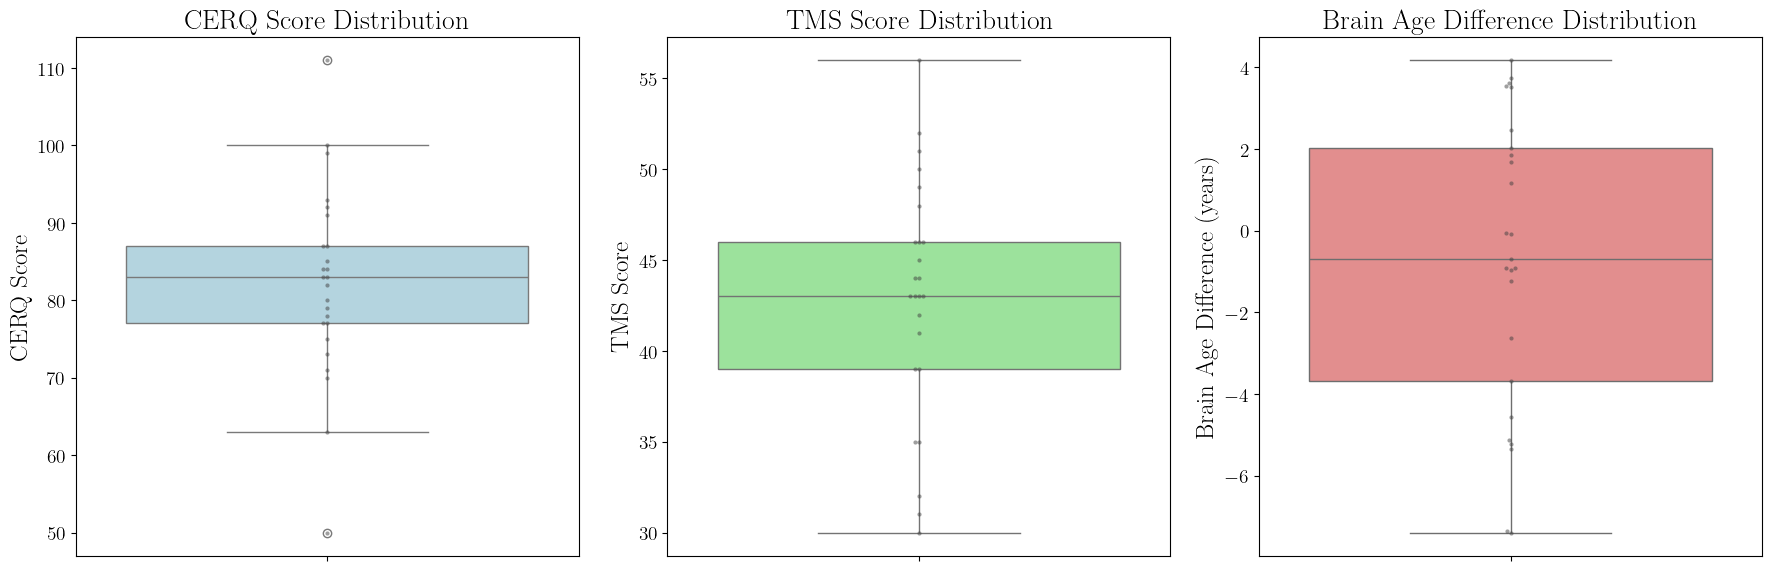

In [5]:
# Create a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# CERQ Score boxplot
sns.boxplot(y=data['CERQ_Score'], ax=ax1, color='lightblue')
sns.swarmplot(y=data['CERQ_Score'], ax=ax1, color=".25", size=3, alpha=0.5)
ax1.set_title('CERQ Score Distribution')
ax1.set_ylabel('CERQ Score')

# TMS Score boxplot
sns.boxplot(y=data['TMS_Score'], ax=ax2, color='lightgreen')
sns.swarmplot(y=data['TMS_Score'], ax=ax2, color=".25", size=3, alpha=0.5)
ax2.set_title('TMS Score Distribution')
ax2.set_ylabel('TMS Score')

# Brain Age Difference boxplot
sns.boxplot(y=data['brain_age_diff'], ax=ax3, color='lightcoral')
sns.swarmplot(y=data['brain_age_diff'], ax=ax3, color=".25", size=3, alpha=0.5)
ax3.set_title('Brain Age Difference Distribution')
ax3.set_ylabel('Brain Age Difference (years)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [6]:
def calculate_percentile_density(data, column, num_percentiles=10):
    # Calculate percentiles
    percentiles = np.percentile(data[column], np.linspace(0, 100, num_percentiles+1))
    
    # Initialize list to store densities
    densities = []
    
    # Calculate density for each percentile range
    for i in range(len(percentiles)-1):
        lower = percentiles[i]
        upper = percentiles[i+1]
        count = ((data[column] >= lower) & (data[column] < upper)).sum()
        densities.append(count)
    
    return percentiles, densities

# Calculate densities for each score
scores = ['CERQ_Score', 'TMS_Score', 'brain_age_diff']

for score in scores:
    percentiles, densities = calculate_percentile_density(data, score)
    
    print(f"\nDensity distribution for {score}:")
    print(f"{'Percentile Range':<20} {'Count':<10}")
    print("-" * 30)
    
    for i in range(len(densities)):
        lower = percentiles[i]
        upper = percentiles[i+1]
        print(f"{f'{lower:.2f} - {upper:.2f}':<20} {densities[i]:<10}")
    
    print(f"Total observations: {sum(densities)}")


Density distribution for CERQ_Score:
Percentile Range     Count     
------------------------------
50.00 - 70.40        3         
70.40 - 74.60        2         
74.60 - 77.20        3         
77.20 - 79.60        2         
79.60 - 83.00        2         
83.00 - 84.00        2         
84.00 - 86.60        3         
86.60 - 91.20        3         
91.20 - 96.60        2         
96.60 - 111.00       2         
Total observations: 24

Density distribution for TMS_Score:
Percentile Range     Count     
------------------------------
30.00 - 33.20        3         
33.20 - 38.20        2         
38.20 - 41.20        3         
41.20 - 43.00        1         
43.00 - 43.00        0         
43.00 - 44.40        6         
44.40 - 46.00        1         
46.00 - 48.20        4         
48.20 - 50.60        2         
50.60 - 56.00        2         
Total observations: 24

Density distribution for brain_age_diff:
Percentile Range     Count     
------------------------------
-7.39 - 

In [8]:
# Shapiro-Wilk test
stat, p_value = shapiro(data['brain_age_diff'].dropna())  

print(f'Statistic: {stat}, p-value: {p_value}')

# Interpret the result
alpha = 0.05
if p_value > alpha:
    print('Brain age difference is normally distributed (fail to reject H0)')
else:
    print('Brain age difference is not normally distributed (reject H0)')

Statistic: 0.9321992564311612, p-value: 0.09769766504321513
Brain age difference is normally distributed (fail to reject H0)


C:\Users\janpa\AppData\Local\Temp\ipykernel_27892\3960125728.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data['brain_age_diff'], shade=True, color='skyblue', ax=ax)


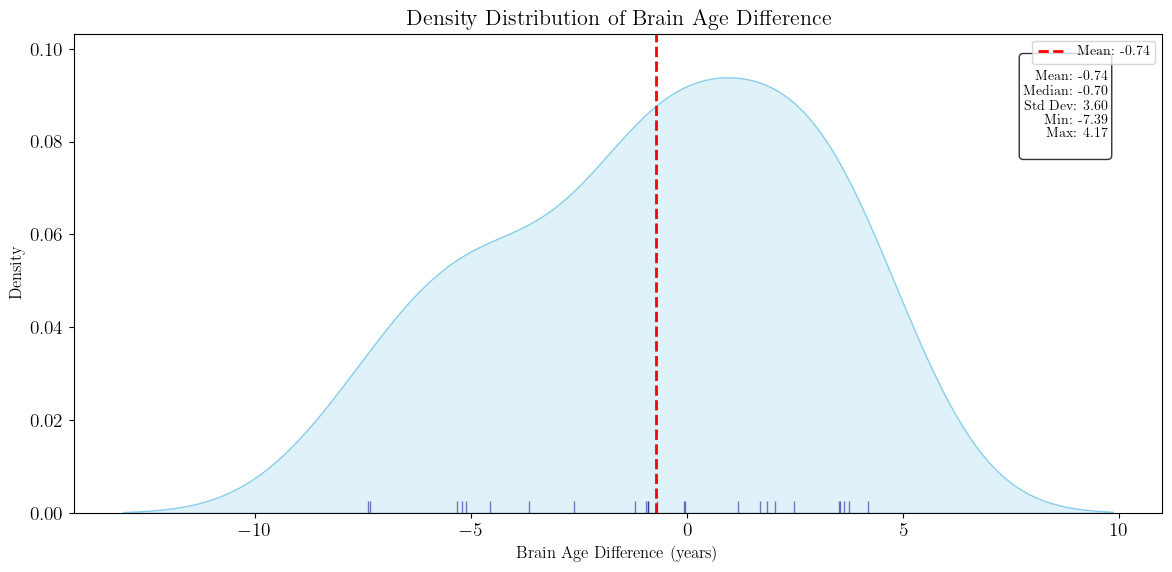

In [9]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create the density plot
sns.kdeplot(data=data['brain_age_diff'], shade=True, color='skyblue', ax=ax)
sns.rugplot(data=data['brain_age_diff'], color='navy', alpha=0.5, ax=ax)

# Add a vertical line for the mean
mean_brain_age_diff = data['brain_age_diff'].mean()
ax.axvline(mean_brain_age_diff, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_brain_age_diff:.2f}')

# Customize the plot
ax.set_title('Density Distribution of Brain Age Difference', fontsize=16)
ax.set_xlabel('Brain Age Difference (years)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

# Add legend
ax.legend(fontsize=10)

# Add descriptive statistics as text
stats_text = f"""
Mean: {data['brain_age_diff'].mean():.2f}
Median: {data['brain_age_diff'].median():.2f}
Std Dev: {data['brain_age_diff'].std():.2f}
Min: {data['brain_age_diff'].min():.2f}
Max: {data['brain_age_diff'].max():.2f}
"""
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Show the plot
plt.tight_layout()
plt.show()

### 4. Definition of hypotheses

> **Hypothesis 1**: Mothers with higher scores on the Toronto Mindfulness Scale (TMS) will have predicted brain ages based on the model of
Leonardsen et al. (2022) that are closer to or younger than their chronological ages.

In [10]:
# Hypothesis 1: Relationship between TMS scores and brain age difference (with age as a covariate)
def test_hypothesis_1(data):
    # Step 1: TMS Score -> Brain Age Difference (controlling for age)
    model = ols('brain_age_diff ~ TMS_Score + age', data=data).fit()
    
    # Generate LaTeX table for the model
    stargazer = Stargazer([model])
    stargazer.title("Hypothesis 1 Results: TMS Score and Brain Age Difference")
    stargazer.custom_columns(["Model 1"], [1])
    stargazer.show_degrees_of_freedom(False)
    
    # Print the LaTeX code
    print(stargazer.render_latex())

    # Visualize the relationship
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='TMS_Score', y='brain_age_diff', data=data)
    plt.title('TMS Score vs Brain Age Difference')
    plt.xlabel('TMS Score')
    plt.ylabel('Brain Age Difference (Chronological - Predicted)')
    plt.show()

> **Hypothesis 2**: The relationship between mindfulness (TMS scores) and brain age is mediated by the participant’s emotional response while watching their infant. Specifically, higher mindfulness (TMS scores) leads to more positive emotional responses when watching the infant express positive emotions and lower intensity of negative emotional responses when watching the infant express negative emotions. These emotional responses, in turn, are associated with younger estimated brain ages.

In [11]:
# Hypothesis 2: Mediation analysis
def test_hypothesis_2(data):
    # Step 1: TMS -> Emotional Responses
    model_pos = ols('PS_OSPV_1 ~ TMS_Score', data=data).fit()
    model_neg = ols('PS_OSNI_1 ~ TMS_Score', data=data).fit()
    
    # Step 2: Emotional Responses -> Brain Age Difference
    model_brain_age = ols('brain_age_diff ~ PS_OSPV_1 + PS_OSNI_1', data=data).fit()
    
    # Step 3: TMS -> Brain Age Difference (with and without mediators)
    model_direct = ols('brain_age_diff ~ TMS_Score + age', data=data).fit()
    model_full = ols('brain_age_diff ~ TMS_Score + PS_OSPV_1 + PS_OSNI_1 + age', data=data).fit()
    
    # Generate LaTeX table for multiple models
    stargazer = Stargazer([model_pos, model_neg, model_brain_age, model_direct, model_full])
    stargazer.title("Hypothesis 2 Results")
    stargazer.custom_columns(["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"], [1, 1, 1, 1, 1])
    stargazer.show_degrees_of_freedom(False)
    
    # Print the LaTeX code
    print(stargazer.render_latex())

> **Hypothesis 3**: Mothers with higher scores on adaptive strategies in the Cognitive Emotion Regulation Questionnaire (CERQ) (e.g., 'I thought about what I could do best') will have younger estimated brain ages relative to their chronological ages.

In [12]:
# Hypothesis 3: Relationship between CERQ scores and brain age difference (with age as a covariate)
def test_hypothesis_3(data):
    # Step 1: CERQ Score -> Brain Age Difference (controlling for age)
    model = ols('brain_age_diff ~ CERQ_Score + age', data=data).fit()
    
    # Generate LaTeX table for the model
    stargazer = Stargazer([model])
    stargazer.title("Hypothesis 3 Results: CERQ Score and Brain Age Difference")
    stargazer.custom_columns(["Model 1"], [1])
    stargazer.show_degrees_of_freedom(False)
    
    # Print the LaTeX code
    print(stargazer.render_latex())

    # Visualize the relationship
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='CERQ_Score', y='brain_age_diff', data=data)
    plt.title('CERQ Score vs Brain Age Difference')
    plt.xlabel('CERQ Score')
    plt.ylabel('Brain Age Difference (Chronological - Predicted)')
    plt.show()

### 5. Testing the hypotheses

\begin{table}[!htbp] \centering
  \caption{Hypothesis 1 Results: TMS Score and Brain Age Difference}
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: brain_age_diff}} \
\cr \cline{2-2}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1}  \\
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 Intercept & 8.328$^{}$ \\
& (6.323) \\
 TMS_Score & 0.032$^{}$ \\
& (0.103) \\
 age & -0.393$^{**}$ \\
& (0.169) \\
\hline \\[-1.8ex]
 Observations & 25 \\
 $R^2$ & 0.199 \\
 Adjusted $R^2$ & 0.127 \\
 Residual Std. Error & 3.360 \\
 F Statistic & 2.740$^{*}$ \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


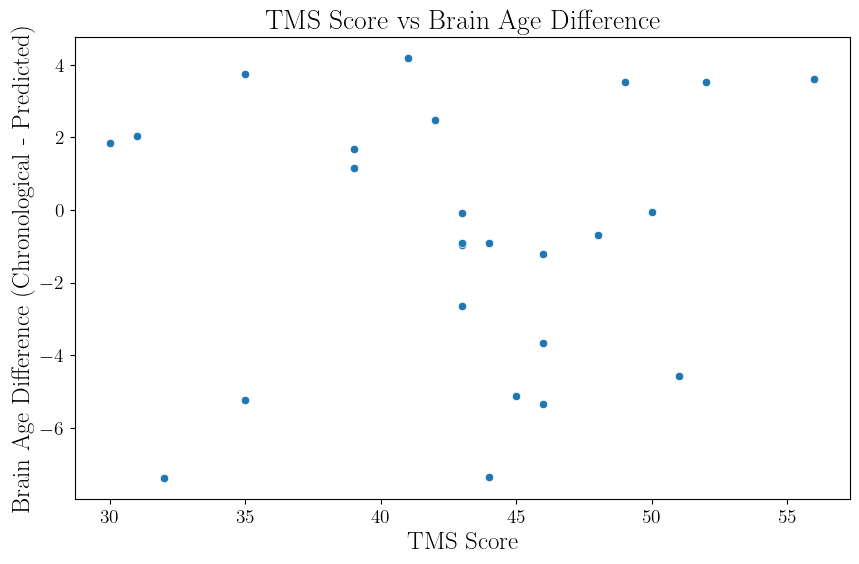

\begin{table}[!htbp] \centering
  \caption{Hypothesis 2 Results}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2} & \multicolumn{1}{c}{Model 3} & \multicolumn{1}{c}{Model 4} & \multicolumn{1}{c}{Model 5}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \\
\hline \\[-1.8ex]
 Intercept & 8.315$^{}$ & 9.623$^{}$ & -0.095$^{}$ & 8.328$^{}$ & 6.693$^{}$ \\
& (32.593) & (46.018) & (2.666) & (6.323) & (7.776) \\
 PS_OSNI_1 & & & 0.025$^{}$ & & 0.008$^{}$ \\
& & & (0.026) & & (0.029) \\
 PS_OSPV_1 & & & -0.023$^{}$ & & -0.007$^{}$ \\
& & & (0.031) & & (0.037) \\
 TMS_Score & 1.820$^{**}$ & 0.985$^{}$ & & 0.032$^{}$ & 0.025$^{}$ \\
& (0.751) & (1.078) & & (0.103) & (0.137) \\
 age & & & & -0.393$^{**}$ & -0.315$^{}$ \\
& & & & (0.169) & (0.228) \\
\hline \\[-1.8ex]
 Observations & 25 & 22 & 22 & 25 & 22 \\
 $R^2$ & 0.204 & 0.040 & 0.056 & 0.199 & 0.154 \\
 Adjusted $R^2$ & 0.169 & -0.008 & -0.043 & 

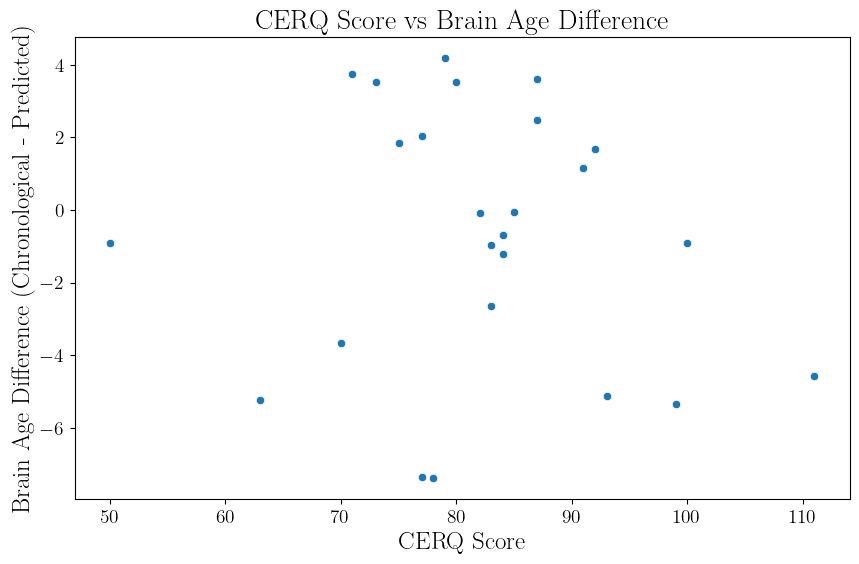

In [13]:
# Run the analyses
test_hypothesis_1(data)
test_hypothesis_2(data)
test_hypothesis_3(data)

In [14]:
# Correction for multiple comparisons
def correct_multiple_comparisons(p_values):
    _, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')
    return corrected_p_values

In [15]:
# Collect p-values from all hypotheses
p_values = [
    ols('brain_age_diff ~ TMS_Score + age', data=data).fit().pvalues['TMS_Score'],  # Hypothesis 1
    
    ols('PS_OSPV_1 ~ TMS_Score', data=data).fit().pvalues['TMS_Score'],  # Hypothesis 2 (Step 1: Positive Valence)
    ols('PS_OSNI_1 ~ TMS_Score', data=data).fit().pvalues['TMS_Score'],  # Hypothesis 2 (Step 1: Negative Intensity)
    ols('brain_age_diff ~ PS_OSPV_1 + PS_OSNI_1', data=data).fit().pvalues['PS_OSPV_1'],  # Hypothesis 2 (Step 2: Positive Valence)
    ols('brain_age_diff ~ PS_OSPV_1 + PS_OSNI_1', data=data).fit().pvalues['PS_OSNI_1'],  # Hypothesis 2 (Step 2: Negative Intensity)
    ols('brain_age_diff ~ TMS_Score + PS_OSPV_1 + PS_OSNI_1 + age', data=data).fit().pvalues['TMS_Score'],  # Hypothesis 2 (Step 3: TMS + Mediators)
    
    ols('brain_age_diff ~ CERQ_Score + age', data=data).fit().pvalues['CERQ_Score']  # Hypothesis 3
]

# Apply Bonferroni correction
corrected_p_values = correct_multiple_comparisons(p_values)

# Print the corrected p-values
print("\nCorrected p-values after Bonferroni correction:")
for i, (original, corrected) in enumerate(zip(p_values, corrected_p_values)):
    print(f"Test {i+1}: Original p-value: {original:.4f}, Corrected p-value: {corrected:.4f}")


Corrected p-values after Bonferroni correction:
Test 1: Original p-value: 0.7587, Corrected p-value: 1.0000
Test 2: Original p-value: 0.0236, Corrected p-value: 0.1652
Test 3: Original p-value: 0.3716, Corrected p-value: 1.0000
Test 4: Original p-value: 0.4574, Corrected p-value: 1.0000
Test 5: Original p-value: 0.3539, Corrected p-value: 1.0000
Test 6: Original p-value: 0.8562, Corrected p-value: 1.0000
Test 7: Original p-value: 0.3261, Corrected p-value: 1.0000


### 6. Plotting Brain Age predictions
Brain Age predictions vs. Chronological Age (to see the accuracy of prediction)

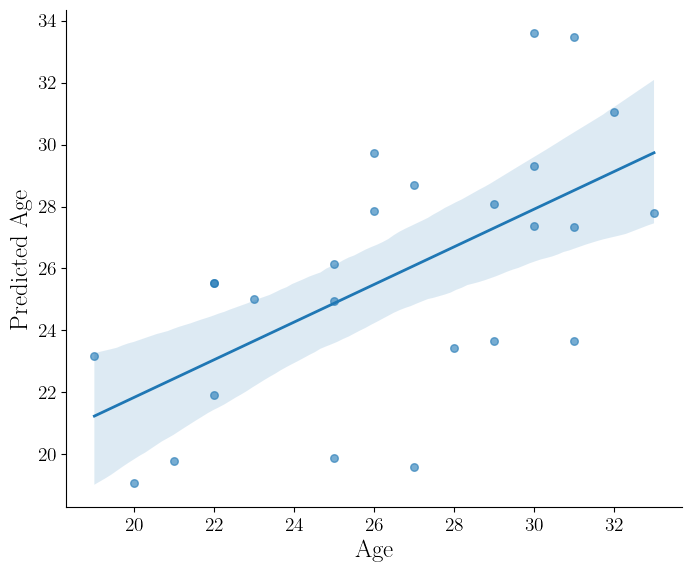

In [60]:
# Plot with seaborn's lmplot, which includes confidence bands by default
sns.lmplot(
    data=data,
    x='age',
    y='predicted_age',
    palette='lightcoral',
    height=6,
    aspect=1.2,
    ci=95,
    markers="o",
    scatter_kws={"s": 30, "alpha": 0.6},
    line_kws={"linewidth": 2}
)

# Customize plot labels and title
plt.xlabel('Age')
plt.ylabel('Predicted Age')
#plt.title('Brain Age prediction: Postnatal Dataset')

# Save and show the plot
plt.savefig("brain_age_postnatal.png", dpi=300)
plt.show()

#### 7. Further tests (model complexity)
Which model to choose?

In [56]:
# Model 1: Maladaptive CERQ score predicting brain age difference
model_original = ols('brain_age_diff ~ CERQ_Maladaptive_Score', data=data).fit()

# Model 2: Maladaptive CERQ score predicting brain age difference, controlling for chronological age
model_with_age = ols('brain_age_diff ~ CERQ_Maladaptive_Score + age', data=data).fit()

# Print summary of both models
print("Model 1: Without controlling for chronological age")
print(model_original.summary())

print("\nModel 2: Controlling for chronological age")
print(model_with_age.summary())

# Compare the models (AIC, BIC, etc.)
print("\nModel Comparison (AIC, BIC, etc.):")
print(f"AIC (Model 1): {model_original.aic}")
print(f"AIC (Model 2): {model_with_age.aic}")

Model 1: Without controlling for chronological age
                            OLS Regression Results                            
Dep. Variable:         brain_age_diff   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     4.519
Date:                Fri, 11 Oct 2024   Prob (F-statistic):             0.0445
Time:                        12:14:10   Log-Likelihood:                -64.714
No. Observations:                  25   AIC:                             133.4
Df Residuals:                      23   BIC:                             135.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------